# Results 3.2 Paired T-Test and Regression Analysis for Muscle Volumes

In this chapter, a paired t-test and regression analysis is performed to compare the reconstructed 3D muscle lengths with experimental measurements.
The results of the analysis and the figures are used in the manuscript in section 3.2 "Accuracy of Muscle Volume and 
Length Reconstructio". . 

## Imports

Required packages for this analysis can be found in the `requirements.txt` file. Ensure that all 
dependencies are installed before running the script.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel
from scipy import stats
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Setting global styles for plots
sns.set(style='white')

# ANSI escape code for bold text in print
bold_start = "\033[1m"
bold_end = "\033[0m"

## 1. Input Setup

Loads the `Muscle_data.xlsx` file containing all original data and removes specimens where 3D reconstructions have not been performed.

In [2]:
# Load the data from the provided Excel file
file_path = os.path.join('Muscle_data.xlsx')
data = pd.read_excel(file_path)

# Filter out specimens with missing data
data = data[~data['Specimen_ID'].isin([130, 131, 129])]

# log transform data
exp_volumes = np.log(data['Volume_exp (cm³)'])
poly_volumes = np.log(data['Volume_rec (cm³)'])
    
# store muscle names and species names    
muscle_names = data['Muscle_Name']
specimen_names = data['Genus']

## 2. Paired T-Test

Performs a paired t-test of the experimental lengths against the reconstructed lengths and prints the t-statistic and p-value. 

In [3]:
# Perform paired t-test to compare reconstructed and experimental measurements
t_stat, p_value = ttest_rel(exp_volumes, poly_volumes)
print(f"Paired t-test t-statistic: {t_stat:.2f}")
print(f"Paired t-test p-value: {bold_start}{p_value:.2f}{bold_end}")

Paired t-test t-statistic: 1.12
Paired t-test p-value: 0.27


## 3. Linear Regression and Visualization

                            OLS Regression Results                            
Dep. Variable:       Volume_rec (cm³)   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     459.4
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           6.54e-19
Time:                        17:06:33   Log-Likelihood:                -4.1266
No. Observations:                  30   AIC:                             12.25
Df Residuals:                      28   BIC:                             15.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1380      0.176  

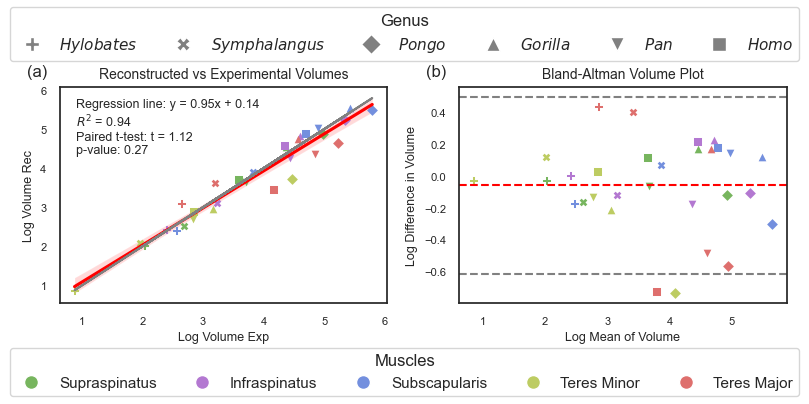

In [4]:
# Perform linear regression
X = sm.add_constant(exp_volumes)
model = sm.OLS(poly_volumes, X).fit()
intercept, slope = model.params
r_squared = model.rsquared

# Print the regression summary in a clear format
print(model.summary())

# Define the desired order of muscle names
desired_order_muscle  = ['Supraspinatus', 'Infraspinatus', 'Subscapularis', 'Teres Minor', 'Teres Major']

# Define the desired order of specimen
desired_order_specimen = ['Hylobates', 'Symphalangus', 'Pongo', 'Gorilla', 'Pan', 'Homo']

# Define the custom colors for each muscle
custom_colors = {
    'Supraspinatus': (0.467, 0.710, 0.367),
    'Infraspinatus': (0.7, 0.47, 0.82),
    'Subscapularis': (0.45, 0.56, 0.87),
    'Teres Minor': (0.741, 0.8, 0.384),
    'Teres Major': (0.871, 0.435, 0.427)
}

# Define unique markers for specimen
custom_markers = {
    'Hylobates': 'P',
    'Symphalangus': 'X',
    'Pongo': 'D',
    'Gorilla': '^',
    'Pan': 'v',
    'Homo': 's'
}


# Create a mapping of muscle names to colors based on the desired order
muscle_to_color = {muscle: custom_colors[muscle] for muscle in desired_order_muscle}

# Create figure for regression and Bland-Altman plots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot Linear Regression (left subplot)
ax1 = axes[0]

# Scatter and regression plot
sns.regplot(x=exp_volumes, y=poly_volumes, ax=ax1, data=data, scatter=False, color='red', label='Regression line')

# Scatter plot of the log-transformed data points
for muscle in desired_order_muscle:
    for specimen in desired_order_specimen:
        mask = (data['Muscle_Name'] == muscle) & (data['Genus'] == specimen)
        ax1.scatter(exp_volumes[mask], poly_volumes[mask], 
                    color=muscle_to_color[muscle], 
                    marker=custom_markers[specimen],
                    linewidths=0.01,
                    s=30)

ax1.plot(exp_volumes, exp_volumes, color='grey')


ax1.set_title('Reconstructed vs Experimental Volumes', fontsize=10)
ax1.set_xlabel('Log Volume Exp', fontsize=9)
ax1.set_ylabel('Log Volume Rec', fontsize=9)
    

equation_text = f'Regression line: y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_squared:.2f}\nPaired t-test: t = {t_stat:.2f}\np-value: {p_value:.2f}'
ax1.annotate(equation_text, 
    xy=(0.05, 0.95), xycoords='axes fraction', fontsize=9, 
    horizontalalignment='left', verticalalignment='top'
)


# Apply custom font to tick labels

ax1.tick_params(axis='both', which='major', labelsize=8)
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_size(8)

# Add annotation "a"
ax1.annotate('(a)', xy=(-0.1, 1.05), xycoords='axes fraction', fontsize=12)




# Plot Bland-Altman Plot (right subplot)
differences = poly_volumes - exp_volumes
means = np.mean([poly_volumes, exp_volumes], axis=0)

ax2 = axes[1]
ax2.axhline(y=np.mean(differences), color='red', linestyle='--')
ax2.axhline(y=np.mean(differences) + 1.96*np.std(differences), color='gray', linestyle='--')
ax2.axhline(y=np.mean(differences) - 1.96*np.std(differences), color='gray', linestyle='--')

for muscle in desired_order_muscle:
    for specimen in desired_order_specimen:
        mask = (muscle_names == muscle) & (specimen_names == specimen)
        ax2.scatter(means[mask], differences[mask], 
                    color=muscle_to_color[muscle], 
                    marker=custom_markers[specimen],
                    linewidths=0.01,
                    s=30)



ax2.set_title('Bland-Altman Volume Plot', fontsize=10)
ax2.set_xlabel('Log Mean of Volume', fontsize=9)
ax2.set_ylabel('Log Difference in Volume', fontsize=9)

# Apply custom font to tick labels

ax2.tick_params(axis='both', which='major', labelsize=8)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_size(8)
    
    
# Add annotation "a"
ax2.annotate('(b)', xy=(-0.1, 1.05), xycoords='axes fraction', fontsize=12)

# Create legends
handles_muscles = [plt.Line2D([0], [0], marker='o', color='w', label=muscle,
                              markerfacecolor=color, markersize=10) 
                   for muscle, color in muscle_to_color.items()]

# Create handles with italicized labels
handles_specimen = [
    plt.Line2D(
        [0], [0],
        marker=marker,
        color='w',
        label=f'${specimen}$',  # Italicize the label here
        markerfacecolor='gray',
        markersize=10
    )
    for specimen, marker in custom_markers.items()
]

# Add legends above and below the plots
fig.legend(handles=handles_specimen, title='Genus', loc='upper center', ncol=6)
fig.legend(handles=handles_muscles, title='Muscles', loc='lower center', ncol=6)

# Display plots with adjusted layout
plt.tight_layout(rect=[0, 0.1, 1, 0.9])  # Leave space for legends
plt.show()

## 4. Error Metrics

Determines the Mean Absolute Error, Root Mean Squared Error and Coefficient of Determination.

In [5]:
# Calculate MAE and RMSE
mae = mean_absolute_error(exp_volumes, poly_volumes)
rmse = np.sqrt(mean_squared_error(exp_volumes, poly_volumes))
r2 = r2_score(exp_volumes, poly_volumes)

# Display error metrics in a table format
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Coefficient of Determination (R²): {r2:.2f}")

Mean Absolute Error (MAE): 0.22
Root Mean Squared Error (RMSE): 0.29
Coefficient of Determination (R²): 0.94


## 5. Tests Difference from Identity Line

In linear regression, we often want to know if the slope is different from 1, which would indicate a deviation from a perfect one-to-one relationship between the variables.
High p-values (above 0.05) would indicate that the slope does not significantly differ from 1 and the intercept does not significantly differ from 0.

In [6]:
intercept_se, slope_se = model.bse  # Standard errors for the intercept and slope
t_stat_slope, t_stat_intercept = model.tvalues  # t-statistics for testing if the slope = 0 and intercept = 0

# Calculating the t-statistic for testing if the intercept is significantly different from 0
# A t-statistic compares the estimated intercept against 0 to check if it is significantly different.
intercept_t_stat = (intercept - 0) / intercept_se

# To test if the slope is significantly different from 1, we adjust the hypothesis:
# Here, we subtract 1 from the estimated slope, then check if the result is significantly different from 0.
t_stat_slope_vs_1 = (slope - 1) / slope_se

# Calculate the p-value for the t-statistic of the slope vs 1
# The p-value indicates the probability of observing this result under the null hypothesis (slope = 1).
p_value_slope_vs_1 = 2 * (1 - stats.t.cdf(abs(t_stat_slope_vs_1), df=len(exp_volumes) - 2))

# Calculate the p-value for testing if the intercept is different from 0
# This p-value helps determine if the intercept differs significantly from 0.
intercept_p_value = 2 * (1 - stats.t.cdf(abs(intercept_t_stat), df=len(exp_volumes) - 2))

# Print the results of the hypothesis tests
print(f"t-statistic for intercept vs 0: {t_stat_intercept:.2f}")
print(f"p-value for intercept vs 0: {bold_start}{intercept_p_value:.2f}{bold_end}")
print(f"t-statistic for slope vs 1: {t_stat_slope_vs_1:.2f}")
print(f"p-value for slope vs 1: {bold_start}{p_value_slope_vs_1:.2f}{bold_end}")

t-statistic for intercept vs 0: 21.43
p-value for intercept vs 0: 0.44
t-statistic for slope vs 1: -1.17
p-value for slope vs 1: 0.25
